# Q-Learning Agent 
---
En este notebook se desarrolla un agente de Q-Learning que aprende a escapar de un pequeño laberinto. Para ello, se diseña un pequeño grid que recrea el puzzle de donde debe escapar, el cual incorpora una meta y un punto de "game over". Adicionalmente, se explora el diseño, testeo y optimización de políticas del agente. Para lograr el objetivo anterior, se definen algunas de las variables del agente de Q-Learning:

**1. Ambiente:** El ambiente corresponde al laberinto en donde se encuentra el agente. Este laberinto consistirá en un grid de tamaño 4x3, el cual incorporá un punto de llegada y un punto de "game over". Adicionalmente, una de las casillas del grid será innacesible (o lo que es lo mismo, tendrá un muro).

**2. Estados:** Los estados del agente corresponderán a la posición (coordenadas) en donde se encuentre. Por ejemplo, el estado del agente en el momento $t$ es $S_{t} = (1, 2)$.

**3. Acciones:** Las acciones que puede tomar el agente son: Arriba ($up$), Abajo ($down$), Derecha ($right$), Izquierda ($left$). En caso en que el agente se "estrelle con un muro", el robot vuelve al estado en donde estaba.

**4. Recompensas:** Para el caso del agente en el laberinto, se incluirá una "penalidad de vida", es decir, cada vez que el agente tome una acción, recibirá una recompensa constante $r$. Si llega a la meta, recibirá una recompensa $R_{win}$ y se pierde $R_{loss}$

<img src="https://miro.medium.com/max/725/1*NyWUkwz1QhrVJj9ygCQ5nA.png" alt="Smiley face" height="300" width="450">

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random

%matplotlib inline

In [2]:
from IPython.display import clear_output

In [3]:
import os
def clear():
    os.system( 'cls' )

In [4]:
# Draw Grid.
def draw_grid(x, y):

    fig1 = plt.figure(figsize=(4, 4))
    ax1 = fig1.add_subplot(111, aspect='equal')

    # Horizontal lines.
    for i in range(0, 6):
        ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
        ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")
    
    # Salida, Meta & GameOver.
    ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
    ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#68FF33"))
    ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#FF5533"))

    # Muros del juego.
    ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
    ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
    ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
    ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
    ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))

    # Limit grid view.
    plt.ylim((0, 1))
    plt.xlim((0, 1))

    # Plot text reward.
    pos_correct = -.02
    plt.text(0.9 + pos_correct, 0.9 + pos_correct, "1", fontsize=16)
    plt.text(0.9 + pos_correct, 0.7 + pos_correct, "-1", fontsize=16)
    plt.scatter(x, y, s = 100, color = "black", marker = "x", edgecolors = "black", zorder = 10)
    
    # Plot grid.
    plt.axis("off")
    plt.show()

In [5]:
# Set walls and paths.
grid_world = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 0, 1, 1, 1]]

In [6]:
# Random agent.
class randomAgent():
    
    def __init__(self):
        self.pos = [0, 0]
        self.actions = ["up", "down", "left", "right"]
        self.living_penalty = -1
        self.total_reward = 0
        
    def selectAction(self):
        action = self.actions[random.randint(0, 3)]
        return action 
    
    def move(self):
        act = self.selectAction()
        previous_pos = self.pos.copy()
        self.total_reward += self.living_penalty
        
        print("Action taken: ", act)
        
        try:
            if(act == "up" and self.pos[1] < 4):
                
                if(grid_world[self.pos[0]][self.pos[1] + 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] + 1]

            elif(act == "down" and self.pos[1] > 0):

                if(grid_world[self.pos[0]][self.pos[1] - 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] - 1]

            elif(act == "left" and self.pos[0] > 0):

                if(grid_world[self.pos[0] - 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] - 1, self.pos[1]]

            elif(act == "right" and self.pos[0] < 4):
                if(grid_world[self.pos[0] + 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] + 1, self.pos[1]]
        except:
            pass
        
    def getPos(self):
        return self.pos

In [53]:
class valueBasedAgent():
    
    def __init__(self):
        self.pos = [0, 0]
        self.actions = ["up", "down", "left", "right"]
        self.living_penalty = -1
        self.total_reward = 0
        
    def selectAction(self):
        action = self.actions[random.randint(0, 3)]
        return action 
    
    def move(self):
        act = self.selectAction()
        previous_pos = self.pos.copy()
        self.total_reward += self.living_penalty
        
        print("Action taken: ", act)
        
        try:
            if(act == "up" and self.pos[1] < 4):
                
                if(grid_world[self.pos[0]][self.pos[1] + 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] + 1]

            elif(act == "down" and self.pos[1] > 0):

                if(grid_world[self.pos[0]][self.pos[1] - 1]) == 1:
                    self.pos = [self.pos[0], self.pos[1] - 1]

            elif(act == "left" and self.pos[0] > 0):

                if(grid_world[self.pos[0] - 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] - 1, self.pos[1]]

            elif(act == "right" and self.pos[0] < 4):
                if(grid_world[self.pos[0] + 1][self.pos[1]]) == 1:
                    self.pos = [self.pos[0] + 1, self.pos[1]]
        except:
            pass
        
    def getPos(self):
        return self.pos

In [48]:
value_matrix = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

------
Action taken:  right
Position:  ( 4 , 4 )


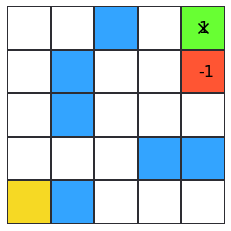

In [7]:
grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]

agent = randomAgent()
pos = agent.getPos()
#print("Position: ", pos[0], pos[1])
draw_grid(pos[0] + 0.1, pos[1] + 0.1)

while not ((pos[0] == 4 and pos[1] == 4) or (pos[0] == 4 and pos[1] == 3)):
    print("------")
    agent.move()
    pos = agent.getPos()
    
    print("Position: ", "(", pos[0], ",", pos[1], ")")
    draw_grid(grid_pos[pos[0]], grid_pos[pos[1]])
    time.sleep(0.1)
    clear_output(wait=True)

In [11]:
class GridWorld():
    
    def __init__(width = 5, height = 5, living_penalty = 0):
        self.width = width, 
        self.height = height,
        self.living_penalty = living_penalty
        
        # State value matrix.
        state_matrix = list()
        for i in range(0, height):
            row_values = list()
    
            for j in range(0, width):
                row_values.append(self.living_penalty)
            state_matrix.append(row_values)
        
        # Action State value matrix.
        action_state_matrix = list()
        for i in range(0, height):
            row_values = list()
            for j in range(0, width):
                state_q_values = list()
                
                for k in range(0, 4):
                    state_q_values.append(0)
                    
                row_values.append(state_q_values)
            action_state_matrix.append(row_values)
                    
    def stateValue():
        return ""
    
    def actionStateValue():
        return ""